In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import sys
import os
import numpy as np
import pandas as pd
import sqlalchemy as sa
import pudl
import pudl.constants as pc
import pudl.extract.ferc1
import datetime

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [4]:
# For some reason these things don't stick if they're in the same cell as the
# %matplotlib inline call above, but if they're separate, they work fine.
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['figure.dpi'] = 100
pd.options.display.max_columns = 56

## High Level US Coal Operating Costs (\$/MWh) from EIA & FERC
 * 200-300 plants total.
 * Get EIA data by generator and FERC data by plant (PUDL and/or FERC Plant IDs)
 * Data years 2012-2017
 * FERC & EIA data mergeable by PUDL Plant ID (manually assigned)
 * Merged FERC data will be aggregated by PUDL Plant ID in cases where there are multiple owners reporting
 * Retain disaggregated FERC data in another Excel tab
 * Minimal data cleaning, relatively raw data output
 * 10 hours at \$75/hour Turn around: early next week.

In [5]:
start_year = 2011
end_year = 2017

In [6]:
pudl_out = pudl.output.pudltabl.PudlTabl(
    freq="MS",
    start_date=pd.datetime(start_year, 1, 1),
    end_date=pd.datetime(end_year, 12, 31))
steam_ferc1 = pudl_out.plants_steam_ferc1()
fuel_ferc1 = pudl_out.fuel_ferc1()

In [7]:
mcoe = pudl_out.mcoe()

/home/zane/anaconda3/envs/pudl/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [8]:
# For each plant record in the plants table, we need to be able to assign
# a fraction of heat content for that plant that came from a particlar fuel
# for filtering purposes. There are different ways that we can aggregate that
# information -- e.g. plant_id_pudl, plant_id_ferc1, (utility_id_ferc1, plant_name)
def coal_fraction(fuel_df, gb_cols=['plant_id_pudl']):
    """
    Calculate the fraction of overall heat content from coal
    per year and per gb_cols, which can be:
      - [plant_id_pudl]
      - [plant_id_ferc1]
      - [utility_id_ferc1, plant_name]
    
    Assumes fuel_df is a fuel_ferc1 dataframe.
    Cannot currently work for arbitrary fuel_type becuase not all plants
    have records for all fuel types.
    """
    gb_cols1 = ['report_year'] + gb_cols
    
    # Total heat content across all fuel types
    total_mmbtu = (
        fuel_df.groupby(gb_cols1).
        agg({'fuel_consumed_mmbtu': sum}).
        reset_index().
        rename(columns={'fuel_consumed_mmbtu': 'total_mmbtu'})
    )
    
    # Same grouping... but also broken down by fuel type
    gb_cols2 = gb_cols1 + ['fuel_type_code_pudl']
    out_df = (
        fuel_df[fuel_df.fuel_type_code_pudl=='coal'].
        groupby(gb_cols2).
        agg({'fuel_consumed_mmbtu': sum}).
        reset_index().
        merge(total_mmbtu, how='left', on=gb_cols1).
        assign(coal_fraction=lambda x: x['fuel_consumed_mmbtu'] / x['total_mmbtu']).
        rename(columns={'fuel_consumed_mmbtu': 'coal_mmbtu'}).
        drop(['fuel_type_code_pudl'], axis=1)
    )
    return out_df

In [9]:
# Calculate total heat content of fuel by plant & year
fuel_consumed_mmbtu = (
    fuel_ferc1.loc[fuel_ferc1.report_year>=start_year,:].
    groupby(['report_year', 'plant_id_pudl']).
    agg({'fuel_consumed_mmbtu': sum}).
    reset_index()
)

coal_fraction_by_plant_name = coal_fraction(fuel_ferc1.loc[fuel_ferc1.report_year>=start_year,:], ['utility_id_ferc1', 'plant_name'])

steam_agg_ferc1 = (
    # Only interested in 2012 and later
    steam_ferc1.loc[steam_ferc1.report_year>=start_year,:].
    # This ensures we only include plants that use *some* coal
    merge(coal_fraction_by_plant_name, how='inner', on=['report_year', 'utility_id_ferc1', 'plant_name']).
    # Break out the non-fuel OpEx
    assign(opex_nonfuel=lambda x: x['opex_production_total'] - x['opex_fuel']).
    # Aggregate by plant_id_pudl
    groupby(['report_year','plant_id_pudl']).
    agg({'capacity_mw': sum,
         'net_generation_mwh': sum,
         'opex_fuel': sum,
         'opex_nonfuel': sum}).
    reset_index().
    # Bring in total heat content per pudl_plant
    merge(fuel_consumed_mmbtu, how='left', on=['report_year', 'plant_id_pudl']).
    # Calculate some other interesting metrics:
    assign(opex_fuel_per_mwh=lambda x: x['opex_fuel'] / x['net_generation_mwh'],
           opex_nonfuel_per_mwh=lambda x: x['opex_nonfuel'] / x['net_generation_mwh'],
           heat_rate_mmbtu_mwh=lambda x: x['fuel_consumed_mmbtu'] / x['net_generation_mwh'],
           capacity_factor=lambda x: x['net_generation_mwh'] / (8760*x['capacity_mw']),
           opex_total_per_mwh=lambda x: x['opex_nonfuel_per_mwh'] + x['opex_fuel_per_mwh'])
)

In [10]:
coal_fraction_by_plant_name.sample(10)

,report_year,utility_id_ferc1,plant_name,coal_mmbtu,total_mmbtu,coal_fraction
1159,2014,182,iatan 1 (18%),8.398002e+06,8.425855e+06,0.996694
1735,2017,6,mountaineer,6.875149e+07,6.899734e+07,0.996437
1165,2014,186,chesterfield,6.511351e+07,6.521983e+07,0.998370
1585,2016,89,elm road 2,3.034240e+06,3.034240e+06,1.000000
282,2011,195,weston 4 (wps share),2.425358e+07,2.430846e+07,0.997743
1862,2017,148,northeastern 3&4,2.237866e+07,2.254873e+07,0.992458
441,2012,95,r.m. heskett,6.357014e+06,6.357768e+06,0.999881
1838,2017,134,craig,1.026569e+07,1.026646e+07,0.999924
1355,2015,108,reid gardner 4,4.264496e+06,4.347820e+06,0.980835
318,2012,1,rockport total plant,1.839999e+08,1.841686e+08,0.999084


In [9]:
truly_bad = [507, 527, 408, 311, 23, 258, 406, 456, 592, 180, 360, 424, 605, 658]
fixes = [
    #(507,  2011, 1000), Reported fuel costs also under by ~10x
    (1117, 2011, 1000),
    (1117, 2012, 1000),
    (125,  2015, 1000),
    (200,  2015, 1000),
    (200,  2016, 1000),
    (200,  2017, 1000),
    (249,  2015, 1000),
    (249,  2016, 1000),
    (249,  2017, 1000),
    (284,  2015, 1000),
    (312,  2015, 1000),
    (607,  2015, 1000),
    (657,  2015, 10),
]

def fix_ferc1_netgen(df, fixes):
    # A few FERC 1 records have errors in their net_generation_mwh column.
    # After identifying these fixes, we need to apply them not only to
    # net_generation_mwh field, but also to the other affected fields:
    #  - opex_fuel_per_mwh
    #  - opex_nonfuel_per_mwh
    #  - heat_rate_mmbtu_mwh
    #  - capacity_factor
    #  - opex_total_per_mwh
    df_out = df.copy()
    for pid, yr, mult in fixes:
        try:
            rownum = df[(df.plant_id_pudl==pid) & (df.report_year==yr)].index[0]
        except:
            continue
        df_out.loc[rownum, 'net_generation_mwh'] = df_out.loc[rownum, 'net_generation_mwh']*mult
        df_out.loc[rownum, 'opex_fuel_per_mwh'] = df_out.loc[rownum, 'opex_fuel_per_mwh']/mult
        df_out.loc[rownum, 'opex_nonfuel_per_mwh'] = df_out.loc[rownum, 'opex_nonfuel_per_mwh']/mult
        df_out.loc[rownum, 'opex_total_per_mwh'] = df_out.loc[rownum, 'opex_total_per_mwh']/mult
        df_out.loc[rownum, 'heat_rate_mmbtu_mwh'] = df_out.loc[rownum, 'heat_rate_mmbtu_mwh']/mult
        df_out.loc[rownum, 'capacity_factor'] = df_out.loc[rownum, 'capacity_factor']*mult
    return(df_out)
steam_agg_ferc1 = fix_ferc1_netgen(steam_agg_ferc1, fixes)

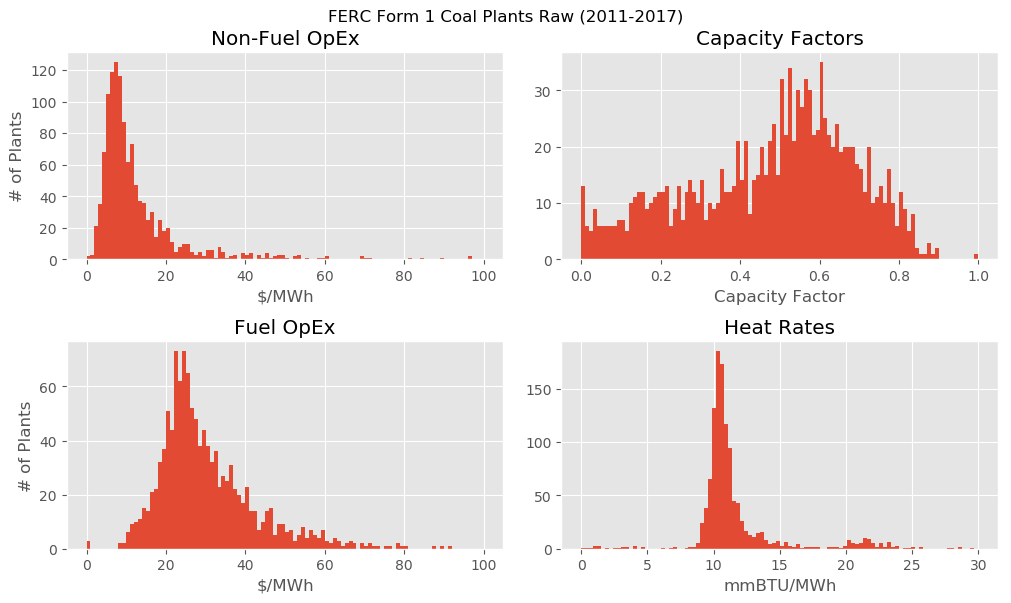

In [10]:
fig, axs = plt.subplots(ncols=2, nrows=2, constrained_layout=True)

fig.suptitle(f'FERC Form 1 Coal Plants Raw ({start_year}-{end_year})')

axs[0,0].hist(steam_agg_ferc1.opex_nonfuel_per_mwh, range=(0,100), bins=100);
axs[0,0].set_title('Non-Fuel OpEx')
axs[0,0].set_xlabel('$/MWh')
axs[0,0].set_ylabel('# of Plants')

axs[0,1].hist(steam_agg_ferc1.capacity_factor, range=(0,1), bins=100);
axs[0,1].set_title('Capacity Factors')
axs[0,1].set_xlabel('Capacity Factor')

axs[1,0].hist(steam_agg_ferc1.opex_fuel_per_mwh, range=(0,100), bins=100)
axs[1,0].set_title('Fuel OpEx')
axs[1,0].set_xlabel('$/MWh')
axs[1,0].set_ylabel('# of Plants')

axs[1,1].hist(steam_agg_ferc1.heat_rate_mmbtu_mwh, range=(0,30), bins=100)
axs[1,1].set_title('Heat Rates')
axs[1,1].set_xlabel('mmBTU/MWh')

plt.savefig('raw_ferc_hist.png')

plt.show();

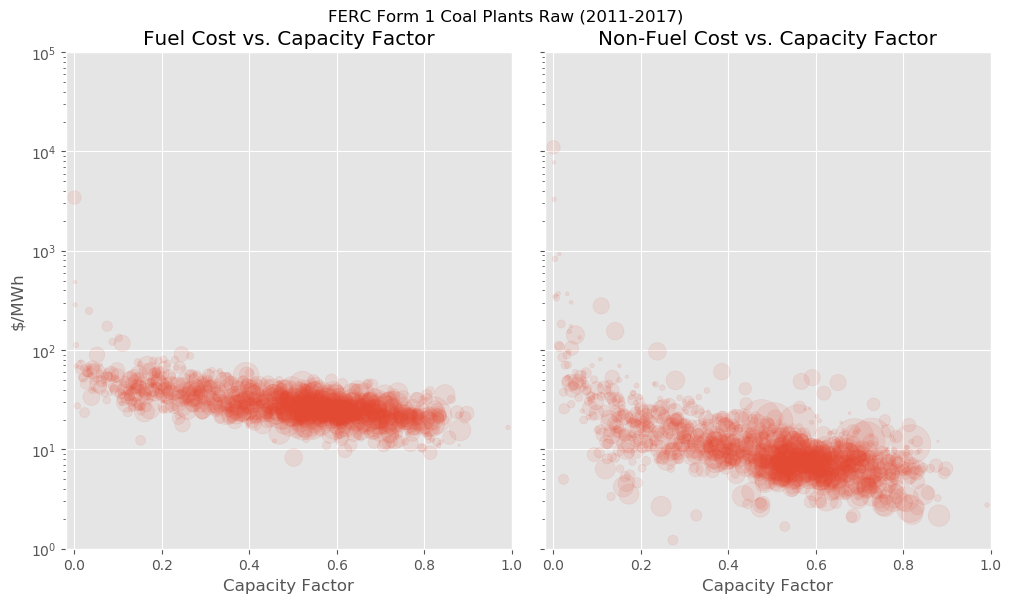

In [11]:
fig, axs = plt.subplots(ncols=2, nrows=1, constrained_layout=True, sharey=True)
fig.suptitle(f'FERC Form 1 Coal Plants Raw ({start_year}-{end_year})')

axs[0].scatter(steam_agg_ferc1.capacity_factor, steam_agg_ferc1.opex_fuel_per_mwh, s=steam_agg_ferc1.capacity_mw/10, alpha=0.1)
axs[0].set_yscale('log')
axs[0].set_xlabel('Capacity Factor')
axs[0].set_xlim(-0.02,1)
axs[0].set_ylabel('$/MWh')
axs[0].set_ylim(1e0,1e4)
axs[0].set_title('Fuel Cost vs. Capacity Factor')

axs[1].scatter(steam_agg_ferc1.capacity_factor, steam_agg_ferc1.opex_nonfuel_per_mwh, s=steam_agg_ferc1.capacity_mw/10, alpha=0.1)
axs[1].set_yscale('log')
axs[1].set_xlabel('Capacity Factor')
axs[1].set_xlim(-0.02,1)
axs[1].set_ylim(1e0,1e5)
axs[1].set_title('Non-Fuel Cost vs. Capacity Factor')

plt.savefig('mcoe_vs_capfac.png')

plt.show();

In [12]:
eia_cols = [
    'report_date',
    'plant_id_eia',
    'plant_id_pudl',
    'unit_id_pudl',
    'generator_id',
    'plant_name',
    'utility_id_eia',
    'utility_id_pudl',
    'utility_name',
    'capacity_factor',
    'capacity_factor_rolling',
    'fuel_cost_per_mwh',
    'fuel_cost_per_mwh_rolling',
    'fuel_type_code_pudl',
    'heat_rate_mmbtu_mwh',
    'heat_rate_mmbtu_mwh_rolling',
    'capacity_mw',
    'net_generation_mwh',
    'net_generation_mwh_rolling',
    'total_fuel_cost',
    'total_fuel_cost_rolling',
    'fuel_cost_per_mmbtu',
    'fuel_cost_per_mmbtu_rolling',
    'total_mmbtu',
    'total_mmbtu_rolling',
]

ferc_cols = [
    'report_year',
    'plant_id_pudl',
    'opex_fuel_per_mwh',
    'opex_nonfuel_per_mwh',
    'heat_rate_mmbtu_mwh',
    'capacity_factor',
    #'capacity_mw',
    #'net_generation_mwh',
    #'opex_fuel',
    #'opex_nonfuel',
    #'fuel_consumed_mmbtu',
]

## Convert EIA data to rolling 12 month averages.
The EIA 923 monthly data is noisy because of variation in plant output. This makes it a little hard to compare directly to the annual FERC data. There are also missing data. We can use rolling sums & forward/back filling to create a smoothed, weighted, rolling averages for the ratios of interest.
### Values of Interest:
 * `heat_rate_mmbtu_mwh`
 * `fuel_cost_per_mwh`
 * `fuel_cost_per_mmbtu`
### Original Values:
 * `net_generation_mwh`
 * `total_fuel_cost`
 * `total_mmbtu`
### For each EIA/PUDL generation unit, we need to:
 * Create a complete time index that spans the time between the first and last records.
 * Merge the real data onto that complete time index
 * Fill the gaps in static 860 data with values from the same year
 * Create a rolling sum for each of the original values
 * Calculate new rolling versions of the values of interest (which are pairwise combinations of original values)

In [13]:
def rolling_mcoe(mcoe_df, win_type='triang', window=12, min_periods=6):
    """
    Calculate rolling sums & averages of key quantities in MCOE outputs.

    The monthly EIA data is noisy and has some gaps for a variety of
    reasons. Calculating rolling annual weighted averages helps smooth
    out a bunch of irregularities, and create a better curve for
    comparison and combination with FERC Form 1 data.
    
    The target quantities that we want to re-calculate are:
     * fuel_cost_per_mwh
     * fuel_cost_per_mmbtu
     * heat_rate_mmbtu_mwh
     * capacity_factor
    
    These quantities depend on the previously calculated:
     * net_generation_mwh
     * total_fuel_cost
     * total_mmbtu
     
    In addition, we need to ensure that the time series is complete,
    i.e. that all the expected timesteps exist, even if they have no
    data associated with them, for the purpose of calculating the
    rolling sums & averages.
    """
    fdr = (
        pd.date_range(start=mcoe_df.report_date.min(),
                      end=mcoe_df.report_date.max(),
                      freq='MS', name='report_date').
        to_frame().
        assign(tmp=1)
    )
    pgids = (
        mcoe_df[['plant_id_eia', 'generator_id']].
        drop_duplicates().
        assign(tmp=1)
    )
    gb = (
        pd.merge(fdr, pgids).
        drop('tmp', axis=1).
        merge(mcoe_df, on=['report_date', 'plant_id_eia', 'generator_id'], how='left').
        set_index('report_date').
        groupby(['plant_id_eia', 'generator_id'])
    )
    rolling_df = (
        gb.rolling(12, win_type='triang', min_periods=6, center=True).
        agg({
            'net_generation_mwh': sum,
            'total_fuel_cost': sum,
            'total_mmbtu': sum
        }).
        reset_index().
        rename(columns={
            'net_generation_mwh': 'net_generation_mwh_rolling',
            'total_fuel_cost': 'total_fuel_cost_rolling',
            'total_mmbtu': 'total_mmbtu_rolling'
        }).
        merge(mcoe_df, how='left', on=['plant_id_eia', 'generator_id', 'report_date']).
        assign(
            heat_rate_mmbtu_mwh_rolling=lambda x: x['total_mmbtu_rolling']/x['net_generation_mwh_rolling'],
            fuel_cost_per_mwh_rolling=lambda x: x['total_fuel_cost_rolling']/x['net_generation_mwh_rolling'],
            fuel_cost_per_mmbtu_rolling=lambda x: x['total_fuel_cost_rolling']/x['total_mmbtu_rolling'],
            capacity_factor_rolling=lambda x: x['net_generation_mwh_rolling']/(8760*x['capacity_mw'])
        ).
        set_index('report_date')
    )
    
    return rolling_df


In [14]:
rolling_df = rolling_mcoe(mcoe)

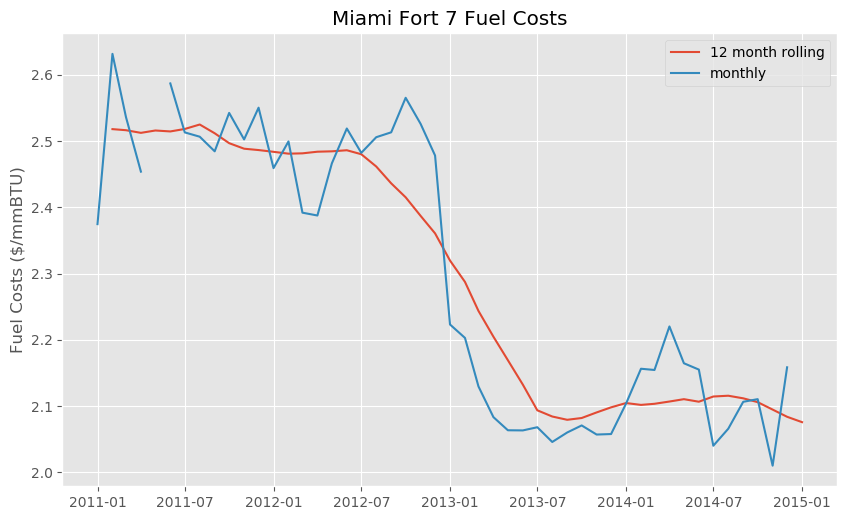

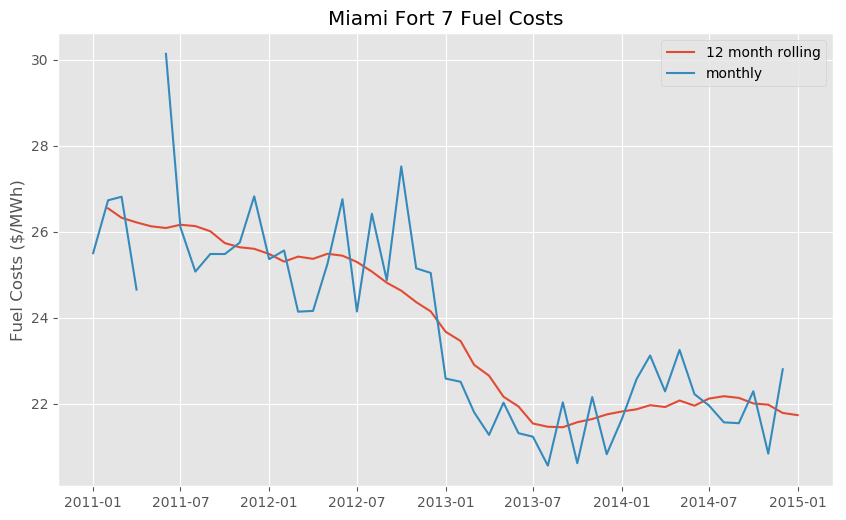

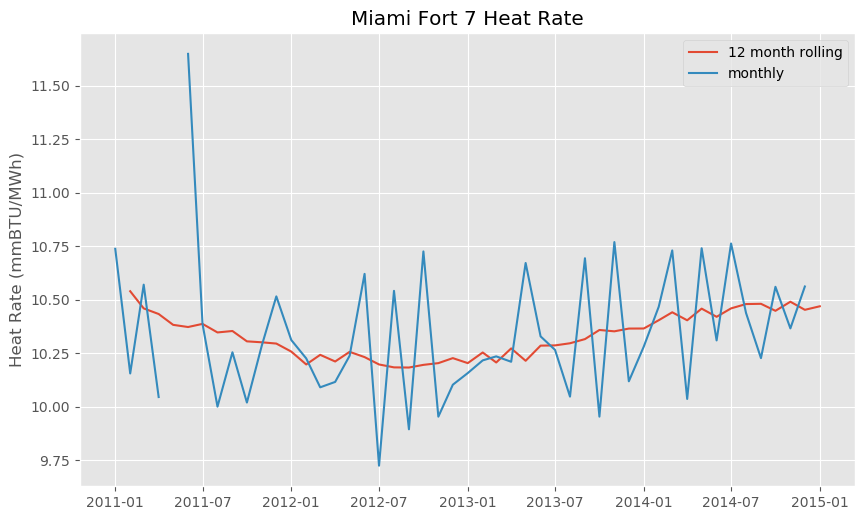

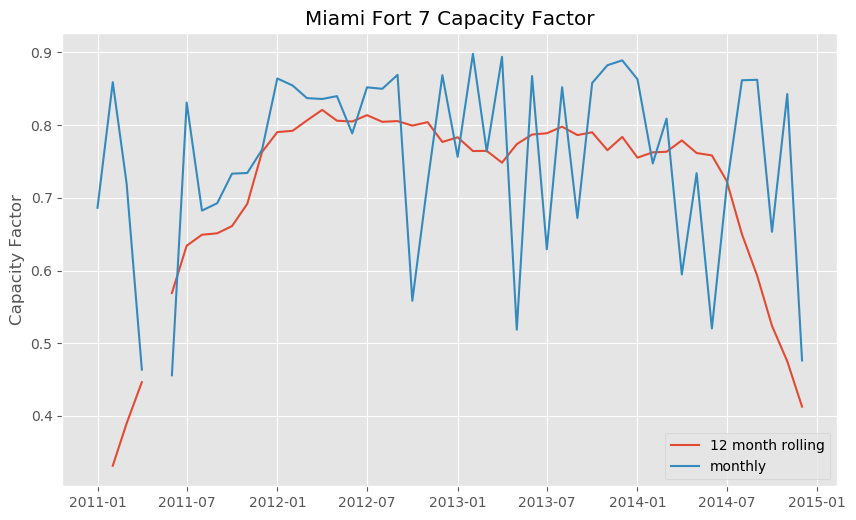

In [15]:
test_pid = np.random.choice(rolling_df.plant_id_eia.unique())
#test_pid = 470
test_plant =  rolling_df[rolling_df.plant_id_eia==test_pid]
test_gid = np.random.choice(test_plant.generator_id.unique())
#test_gid = '3'

test_gen = rolling_df[
    (rolling_df.plant_id_eia == test_pid) &
    (rolling_df.generator_id == test_gid)
]

plant_name = test_gen.plant_name.dropna().unique()[0]

plt.plot(test_gen.index, test_gen.fuel_cost_per_mmbtu_rolling, label="12 month rolling")
plt.plot(test_gen.index, test_gen.fuel_cost_per_mmbtu, label="monthly")
plt.ylabel("Fuel Costs ($/mmBTU)")
plt.title(f"{plant_name} {test_gid} Fuel Costs")
plt.legend()
plt.savefig('Test_RollHeatCost.png')
plt.show()

plt.plot(test_gen.index, test_gen.fuel_cost_per_mwh_rolling, label="12 month rolling")
plt.plot(test_gen.index, test_gen.fuel_cost_per_mwh, label="monthly")
plt.ylabel("Fuel Costs ($/MWh)")
plt.title(f"{plant_name} {test_gid} Fuel Costs")
plt.legend()
plt.savefig('Test_RollMWhCost.png')
plt.show()

plt.plot(test_gen.index, test_gen.heat_rate_mmbtu_mwh_rolling, label="12 month rolling")
plt.plot(test_gen.index, test_gen.heat_rate_mmbtu_mwh, label="monthly")
plt.ylabel("Heat Rate (mmBTU/MWh)")
plt.title(f"{plant_name} {test_gid} Heat Rate")
plt.legend()
plt.savefig('Test_RollHeatRate.png')
plt.show()

plt.plot(test_gen.index, test_gen.capacity_factor_rolling, label="12 month rolling")
plt.plot(test_gen.index, test_gen.capacity_factor, label="monthly")
plt.ylabel("Capacity Factor")
plt.title(f"{plant_name} {test_gid} Capacity Factor")
plt.legend()
plt.savefig('Test_RollCapFac.png')
plt.show()

## Merging FERC & EIA together
* FERC is annual, EIA is monthly
* Before we kept EIA monthly b/c some years had bad (NA) months and aggregating to annual meant losing the whole year.
* This means that the merge has a *lot* of FERC data duplication
* Annual records are broadcast across all months of EIA
* PUDL Plant ID level aggregation is broadcast across all unit_id_pudl values in EIA
* Different sampling scales (both time and generation unit granularity) means only ratio are comparable
* Can compare cost / MWh but not absolute cost, heat rate but not fuel heat content.
* Need to figure out a way to plot this data for a single plant such that it's visually clear how well EIA & FERC values match
* Can do a scatter plot of the same values from both datasets (perfect match = diagonal line)
* Can plot the same values in both datasets against time on the x-axis

In [35]:
rolling_df = rolling_df.reset_index()
plant_ids_2017 = rolling_df[(rolling_df.report_date.dt.year==end_year) &
                            (rolling_df.fuel_type_code_pudl=='coal')].plant_id_pudl.unique()
mcoe_both = (
    # Keep only the relevant mcoe_cols
    rolling_df.loc[:,eia_cols].reset_index().
    # Keep only record pertaining to plants that reported in 2017
    loc[(rolling_df.plant_id_pudl.isin(plant_ids_2017)) &
        (rolling_df.fuel_type_code_pudl=='coal'),:].
    #drop(['fuel_type_code_pudl'], axis=1).
    # Create an EIA report year to merge on
    assign(report_year=lambda x: x['report_date'].dt.year).
    rename(columns={'fuel_cost_per_mwh':'opex_fuel_per_mwh'}).
    # Merge with FERC on year and plant_id_pudl
    merge(steam_agg_ferc1[ferc_cols], how='left', on=['report_year', 'plant_id_pudl'], suffixes=('_eia', '_ferc')).
    drop('index', axis=1)
)

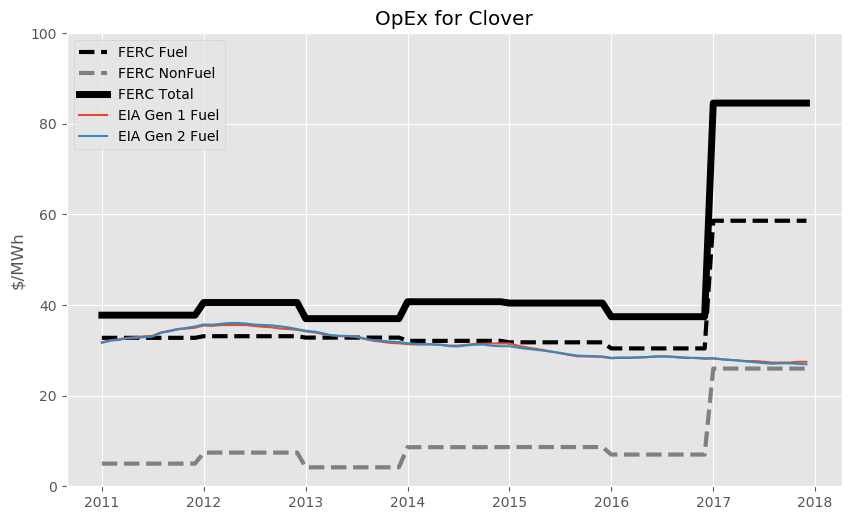

In [17]:
# choose a random plant:
pid=np.random.choice(mcoe_both.plant_id_pudl.unique())
mcoe_test = (
    mcoe_both.loc[mcoe_both.plant_id_pudl==pid,:].
    sort_values(['report_date', 'unit_id_pudl']).
    assign(opex_total_per_mwh_ferc=lambda x: x['opex_fuel_per_mwh_ferc'] +x['opex_nonfuel_per_mwh'])
)
plt.plot(mcoe_test.report_date, mcoe_test.opex_fuel_per_mwh_ferc, label="FERC Fuel", lw=3, color='black', ls='dashed')
plt.plot(mcoe_test.report_date, mcoe_test.opex_nonfuel_per_mwh, label="FERC NonFuel", lw=3, color='gray', ls='dashed')
plt.plot(mcoe_test.report_date, mcoe_test.opex_total_per_mwh_ferc, label="FERC Total", lw=5, color='black')

for unit_id in mcoe_test.unit_id_pudl.unique():
    mcoe_unit = mcoe_test[mcoe_test.unit_id_pudl==unit_id]
    for gen_id in mcoe_unit.generator_id.unique():
        eia_gen = mcoe_unit[mcoe_unit.generator_id==gen_id]
        plt.plot(eia_gen.report_date, eia_gen.fuel_cost_per_mwh_rolling, label=f"EIA Gen {gen_id} Fuel")
    #plt.plot(mcoe_unit.report_date, mcoe_unit.opex_fuel_per_mwh_eia, label=f"EIA Unit {unit_id} Fuel")
plant_name = mcoe_test.plant_name.unique()[0]
plt.title(f'OpEx for {plant_name}')
plt.ylabel("$/MWh")
plt.ylim(0,100)
plt.legend()
plt.show()
#mcoe_test

## Classify Missing EIA Plants
There are some 2015 EIA 860 units which appear to be missing from the 2017 EIA 860 coal plant data collected above. We need to categorize them:
* Truly missing (the plant and generator unit ID listed in 2015 data do not appear in 2017 data)
* Plant & Unit IDs listed do not correspond to coal plants (fuel_type_code_pudl and energy_source_code_1 are not coal-related)
* The plant is listed as retired in the 2017 data.
* No valid fuel cost data was reported for the years 2012-2017
* No valid generation data was reported for the years 2012-2017
* ??? Other reasons ???

In [18]:
gens_eia860 = pudl_out.gens_eia860()
missing_gens = (
    pd.read_excel('missing.xlsx').astype({'Gen ID': str}).
    rename(columns={'ORSPL': 'plant_id_eia',
                    'Gen ID': 'generator_id',
                    'Plant Name': 'plant_name',
                    'Utility': 'utility_id_eia',
                    'State': 'state',
                    'Op Status': 'op_status'})
)
existing_gens = gens_eia860[(gens_eia860.report_date.dt.year==end_year)]
shared_gens = pd.merge(missing_gens, existing_gens, on=['plant_id_eia', 'generator_id'], how='left')
categorized_gens = missing_gens.copy().drop(['op_status', 'state'], axis=1)

# Generators we have no record of in the 2017 data
no_2017 = shared_gens[shared_gens.report_date.isnull()][['plant_id_eia', 'generator_id']]
no_2017['no_2017'] = True
categorized_gens = pd.merge(categorized_gens, no_2017, how='left')
categorized_gens['no_2017'] = categorized_gens.no_2017.fillna(False)

# Generators which are not coal
not_coal = shared_gens[shared_gens.fuel_type_code_pudl!='coal'][['plant_id_eia', 'generator_id']]
not_coal['not_coal'] = True
categorized_gens = pd.merge(categorized_gens, not_coal, how='left')
categorized_gens['not_coal'] = categorized_gens.not_coal.fillna(False)

# Generators which are retired.
retired = shared_gens[shared_gens.operational_status_code=='retired'][['plant_id_eia', 'generator_id']]
retired['retired'] = True
categorized_gens = pd.merge(categorized_gens, retired, how='left')
categorized_gens['retired'] = categorized_gens.retired.fillna(False)

# Figure out which plants have no fuel records.
def missing_coal_costs(plant_ids, pudl_out, years=range(start_year,end_year+1)):
    frc_eia923 = pudl_out.frc_eia923()
    missing_costs = []
    for pid in plant_ids:
        recs = frc_eia923[
            (frc_eia923.plant_id_eia==pid) &
            (frc_eia923.fuel_type_code_pudl=='coal') &
            (frc_eia923.report_date.dt.year.isin(years)) &
            (~frc_eia923.total_fuel_cost.isnull())
        ]
        if len(recs)==0:
            missing_costs.append(pid)
    return missing_costs

missing_costs = missing_coal_costs(missing_gens.plant_id_eia.unique(), pudl_out)
missing_costs = missing_gens[(missing_gens.plant_id_eia.isin(missing_costs))]
missing_costs = missing_costs[['plant_id_eia', 'generator_id']]
missing_costs['missing_costs'] = True
categorized_gens = pd.merge(categorized_gens, missing_costs, how='left')
categorized_gens['missing_costs'] = categorized_gens.missing_costs.fillna(False)


def missing_net_gen(missing_gens, pudl_out, years=range(start_year,end_year+1)):
    missing_gens = missing_gens.copy()[['plant_id_eia', 'generator_id']]
    gen_eia923 = pudl_out.gen_eia923()
    recs_to_check = pd.merge(missing_gens, gen_eia923, how='left')
    missing_netgen = []
    for ids in missing_gens.itertuples(index=False):
        recs = recs_to_check[
            (recs_to_check.plant_id_eia==ids.plant_id_eia) &
            (recs_to_check.generator_id==ids.generator_id) &
            (recs_to_check.report_date.dt.year.isin(years)) &
            (~recs_to_check.net_generation_mwh.isnull())
        ]
        if len(recs)==0:
            missing_netgen.append((ids.plant_id_eia, ids.generator_id))
    return pd.DataFrame.from_records(missing_netgen, columns=['plant_id_eia', 'generator_id'])

missing_gen = missing_net_gen(missing_gens, pudl_out)
missing_gen['missing_gen'] = True
categorized_gens = pd.merge(categorized_gens, missing_gen, how='left')
categorized_gens['missing_gen'] = categorized_gens.missing_gen.fillna(False)


uncategorized_gens = categorized_gens[
    (~categorized_gens.no_2017) &
    (~categorized_gens.not_coal) &
    (~categorized_gens.retired) &
    (~categorized_gens.missing_costs) &
    (~categorized_gens.missing_gen)
]
print(f"Uncategorized Generators: {len(uncategorized_gens)}")
uncategorized_gens.drop('#', axis=1).to_csv('uncategorized_missing_gens.csv', index=False)
categorized_gens.drop('#', axis=1).to_csv('categorized_missing_gens.csv', index=False)

Uncategorized Generators: 33


In [69]:
now = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
with pd.ExcelWriter(f'rough_coal_mcoe_{now}.xlsx') as writer:
    mcoe_both.to_excel(writer, sheet_name='FERC and EIA', index=False)
    steam_agg_ferc1.to_excel(writer, sheet_name='FERC Source Data', index=False)
    (
        rolling_df.drop('index', axis=1).
        loc[(rolling_df.plant_id_pudl.isin(plant_ids_2017)) &
            (rolling_df.fuel_type_code_pudl=='coal'),:].
        to_excel(writer, sheet_name='EIA Source Data', index=False)
    )